# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [1]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [2]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


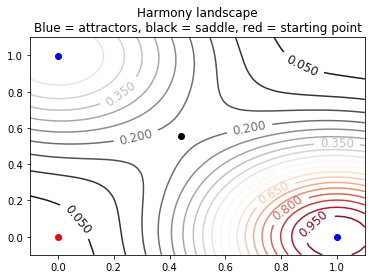

In [3]:
# Plotting the harmony landscape and fixed points
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [4]:
# Now we can calculate the integral shown above
# Takes a few seconds...
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [5]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(dr)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

**Let's assume dyn. w/i an attr. basin is approx. by single Gaussian, which is analytically simpler (pos. linearize w/i attr. basin).**

## Part the second: Relative harmony heights and reading times

Here's the plan for this part: Start with the two harmony peaks at the same height $h_0 = h_1 = 1.0$. Do 2000 runs (using 1000 was still a bit noisy) with $\mathbf{x}_{init} = [0, 0]^\intercal$, $h_0 = 1.0$, and $\gamma = 0.25$, recording which attractor is chosen and how long it takes. After that, I'll gradually lower $h_1$ in increments of 0.05. The hope is that the mean RT for all runs will decrease as $h_1 \rightarrow 0.0$. The lower harmony of $\mathbf{x}_1$ should, on the one hand, make approaches to it much slower, on the other hand, $\mathbf{x}_0$ will be chosen more often, so the average RT should go down.

In [6]:
# Running the Monte-Carlo simulations
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 2000
data_list = []
hvals = np.arange(1.0, 0.0, -0.05)

for h in range(len(hvals)):
    harmonies[1] = hvals[h]
    print('\nh_1 = {}'.format(hvals[h]))
    for run in range(nruns):
        if run % 500 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([hvals[h], 'A', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([hvals[h], 'B', t])
        else:
            data_list.append([hvals[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 1.0
[0] [500] [1000] [1500] 
h_1 = 0.95
[0] [500] [1000] [1500] 
h_1 = 0.8999999999999999
[0] [500] [1000] [1500] 
h_1 = 0.8499999999999999
[0] [500] [1000] [1500] 
h_1 = 0.7999999999999998
[0] [500] [1000] [1500] 
h_1 = 0.7499999999999998
[0] [500] [1000] [1500] 
h_1 = 0.6999999999999997
[0] [500] [1000] [1500] 
h_1 = 0.6499999999999997
[0] [500] [1000] [1500] 
h_1 = 0.5999999999999996
[0] [500] [1000] [1500] 
h_1 = 0.5499999999999996
[0] [500] [1000] [1500] 
h_1 = 0.49999999999999956
[0] [500] [1000] [1500] 
h_1 = 0.4499999999999995
[0] [500] [1000] [1500] 
h_1 = 0.39999999999999947
[0] [500] [1000] [1500] 
h_1 = 0.3499999999999994
[0] [500] [1000] [1500] 
h_1 = 0.2999999999999994
[0] [500] [1000] [1500] 
h_1 = 0.24999999999999933
[0] [500] [1000] [1500] 
h_1 = 0.1999999999999993
[0] [500] [1000] [1500] 
h_1 = 0.14999999999999925
[0] [500] [1000] [1500] 
h_1 = 0.0999999999999992
[0] [500] [1000] [1500] 
h_1 = 0.049999999999999156
[0] [500] [1000] [1500] 

In [7]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0       1.0         A   173
0       1.0         B   184
0       1.0         A   172
0       1.0         A   125
0       1.0         A   186
   Harmony1 Attractor  Time
0      0.05         A   117
0      0.05         A   142
0      0.05         A   125
0      0.05         A   165
0      0.05         A   137


In [8]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                        
           count      mean        std    min    25%    50%    75%    max
Harmony1                                                                
0.05      2000.0  143.4985  20.038083   97.0  129.0  141.0  154.0  243.0
0.10      2000.0  144.3200  20.301396   94.0  130.0  141.0  155.0  282.0
0.15      2000.0  144.2485  20.823149   97.0  130.0  141.0  155.0  252.0
0.20      2000.0  144.8165  21.077238  103.0  130.0  142.0  156.0  289.0
0.25      2000.0  145.5105  21.203412   93.0  130.0  142.0  158.0  244.0
0.30      2000.0  145.2295  21.444131   94.0  130.0  142.0  156.0  259.0
0.35      2000.0  146.4285  21.816229  101.0  132.0  143.5  158.0  279.0
0.40      2000.0  146.4620  21.899688   97.0  132.0  143.0  157.0  309.0
0.45      2000.0  147.7640  23.294584  103.0  132.0  144.0  159.0  330.0
0.50      2000.0  149.9000  24.383012  100.0  133.0  146.0  162.0  351.0
0.55      2000.0  151.1040  25.961051   98.0  134.0  146.0  163.0  320.0
0.60      2000.0  153.1615  27.639381  103.0  134.0  148.0  165.0  317.0
0.65      2000.0  155.0255  27.945166   97.0  135.0  149.0  169.0  301.0
0.70      2000.0  156.7410  28.822618  104.0  137.0  151.0  170.0  307.0
0.75      2000.0  158.1500  27.634260  103.0  138.0  153.0  173.0  301.0
0.80      2000.0  160.1410  27.967091  104.0  139.0  156.0  177.0  313.0
0.85      2000.0  159.5155  26.828579  101.0  140.0  155.0  174.0  278.0
0.90      2000.0  158.3530  25.364465  101.0  141.0  154.5  172.0  301.0
0.95      2000.0  156.4610  23.170108  105.0  140.0  153.0  170.0  285.0
1.00      2000.0  152.5815  22.840057  106.0  136.0  149.0  165.0  256.0

In [9]:
data.groupby(['Attractor', 'Harmony1']).describe()  # basic info by attractor

Time                                               \
                     count        mean        std    min     25%    50%   
Attractor Harmony1                                                        
A         0.05      2000.0  143.498500  20.038083   97.0  129.00  141.0   
          0.10      2000.0  144.320000  20.301396   94.0  130.00  141.0   
          0.15      2000.0  144.248500  20.823149   97.0  130.00  141.0   
          0.20      2000.0  144.816500  21.077238  103.0  130.00  142.0   
          0.25      2000.0  145.510500  21.203412   93.0  130.00  142.0   
          0.30      2000.0  145.229500  21.444131   94.0  130.00  142.0   
          0.35      2000.0  146.428500  21.816229  101.0  132.00  143.5   
          0.40      1998.0  146.334334  21.506816   97.0  132.00  143.0   
          0.45      2000.0  147.764000  23.294584  103.0  132.00  144.0   
          0.50      1989.0  149.233786  22.582782  100.0  133.00  146.0   
          0.55      1976.0  149.961032  23.687480   98.0  134.00  146.0   
          0.60      1951.0  151.146079  24.443272  103.0  134.00  147.0   
          0.65      1912.0  152.282427  24.685351   97.0  135.00  148.0   
          0.70      1857.0  153.037695  25.274840  104.0  135.00  149.0   
          0.75      1764.0  153.503401  24.305731  103.0  136.75  149.0   
          0.80      1643.0  154.670116  25.176662  104.0  137.00  150.0   
          0.85      1525.0  154.289180  24.599061  101.0  137.00  150.0   
          0.90      1358.0  153.939617  24.148537  101.0  137.00  150.0   
          0.95      1181.0  154.037257  22.607902  105.0  138.00  150.0   
          1.00       965.0  152.390674  23.501561  106.0  136.00  149.0   
B         0.40         2.0  274.000000  49.497475  239.0  256.50  274.0   
          0.50        11.0  270.363636  37.569330  211.0  251.50  265.0   
          0.55        24.0  245.208333  32.300194  197.0  228.25  241.5   
          0.60        49.0  233.408163  28.347485  188.0  213.00  229.0   
          0.65        88.0  214.625000  28.286836  154.0  196.75  211.5   
          0.70       143.0  204.832168  28.926567  156.0  185.00  199.0   
          0.75       236.0  192.881356  26.276005  142.0  173.00  191.0   
          0.80       357.0  185.319328  26.352920  133.0  167.00  184.0   
          0.85       475.0  176.294737  26.831429  117.0  158.00  172.0   
          0.90       642.0  167.688474  25.362572  120.0  150.00  163.0   
          0.95       819.0  159.956044  23.535605  108.0  143.00  157.0   
          1.00      1035.0  152.759420  22.215471  106.0  137.00  150.0   

                                   
                       75%    max  
Attractor Harmony1                 
A         0.05      154.00  243.0  
          0.10      155.00  282.0  
          0.15      155.00  252.0  
          0.20      156.00  289.0  
          0.25      158.00  244.0  
          0.30      156.00  259.0  
          0.35      158.00  279.0  
          0.40      157.00  253.0  
          0.45      159.00  330.0  
          0.50      161.00  288.0  
          0.55      162.00  278.0  
          0.60      163.00  312.0  
          0.65      165.00  288.0  
          0.70      165.00  279.0  
          0.75      167.00  284.0  
          0.80      169.00  300.0  
          0.85      168.00  269.0  
          0.90      169.00  258.0  
          0.95      168.00  254.0  
          1.00      165.00  256.0  
B         0.40      291.50  309.0  
          0.50      273.50  351.0  
          0.55      266.50  320.0  
          0.60      246.00  317.0  
          0.65      233.25  301.0  
          0.70      218.50  307.0  
          0.75      209.00  301.0  
          0.80      201.00  313.0  
          0.85      190.00  278.0  
          0.90      181.00  301.0  
          0.95      173.00  285.0  
          1.00      166.00  248.0

In [10]:
# Calculating descriptive statistics for plotting
byharmony = data.groupby(['Harmony1', 'Attractor']).agg('count')
props = byharmony.groupby(level=0).apply(lambda x: x / x.sum())
propa = props.xs('A', level=1)  # Proportions of A-parses by h1 harmony

means = data.groupby('Harmony1').describe().iloc[:, 1]  # Mean settling times

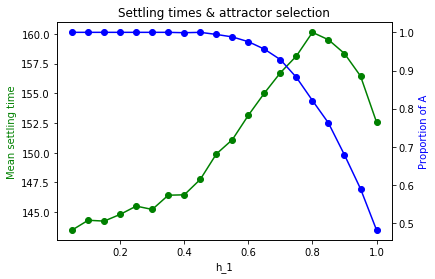

In [11]:
# Making a figure of mean settling time and proportion of A attractors
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(means, 'g-o')
ax2.plot(propa, 'b-o')

ax1.set_xlabel('h_1')
ax1.set_ylabel('Mean settling time', color='g')
ax2.set_ylabel('Proportion of A', color='b')
plt.title('Settling times & attractor selection')
plt.show()

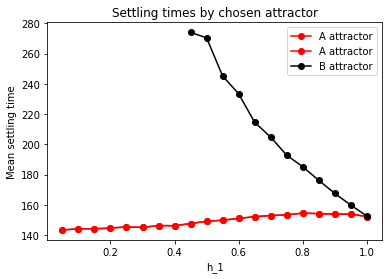

In [13]:
# Looking at the settling times by attractor chosen and h1
rts = data.groupby(['Attractor', 'Harmony1']).describe().iloc[:, 1]
plt.plot(hvals[::-1], rts.xs('A'), 'r-o', label='A attractor')
plt.plot(hvals[0:len(rts.xs('B')),][::-1], rts.xs('B'), 'k-o', label='B attractor')
plt.title('Settling times by chosen attractor')
plt.ylabel('Mean settling time')
plt.xlabel('h_1')
plt.legend()
plt.show()


## Discussion

In this second part, we see an unexpected nonlinear relationship between the relative harmony heights and the settling times. One part of our expectation was borne out: When one attractor has high harmony and the other attractor has low harmony, the average settling times were fast. The system always chooses the high-harmony attractor, and it gets there fast due to its high harmony.

As the harmony of the lower-harmony peak increases, so does the average settling time. But this pattern only holds for a while. After the lower-harmony peak reaches about $h_1 = 0.9$, the average settling time starts to *decrease*. This is because the system starts choosing the lower-harmony peak more often at the same as it's getting faster to approach that attractor. When the two attractors have equal harmony (1.0), the average reading time is still higher than when the two were very unbalanced in harmony.

This makes a really interesting and, as far as I know, unique prediction for sentence processing. When there are two parses available, one high- and one low-harmony, reading times should be fast because the parser will easily choose the high-harmony parse. Reading times should be slower when the two parses are evenly matched in harmony. But this  competition-based slowdown should actually be stronger when the competing parses are only slightly unbalanced in their well-formedness.

The tricky news: picking the $h_i$ is really important because of the nonlinear relationship between it and settling times. 

Model is generally plausible: it seems to get things roughly right, esp. increasing green curve for high competition makes sense for a lot of psycholing. data. But there's a non-trivial subtlety in the up ranges that hasn't been tested yet.

Ambiguity advantage?: "the driver/car of the car/driver with the mustache" both show interference, which might be part of upper part of green curve. Some (Vasishth, Ferreira) seem to want dual attch., but we might expect this to fall out of nature of dyn.... Something like GP would be big difference between harmonies of competitors.

Need compelling reason to use this approach, and then say, "Look, it makes this really cool prediction." Selling points: predicts errant behaviors via normal processing, and we have principled analysis to understand them. 

**Look at how the green curve relates to the black and red ones: is it just weighted by the blue curve.**

**Pos. have one simpler model for illustration/details and another full-fledged one for generality.**

# Part the third: Varying gamma and h together -> 3D plot

Track down PW's comment on rel. mag. of eigenvalues of dyn. and noise mag.: There, he was concerned with the baseline constraint, the strength of which should be greater than the largest absolute eigenvalue of the grammatical weight matrix. For our purposes, I think we can make an analogous approach: For the deterministic dynamics to dominate trajectories near a fixed point, the eigenvalues of the Jacobian matrix should be larger than the eigenvalues of the noise magnitude matrix. Since the noise magnitude matrix is a diagonal matrix with identical values $D$, the largest absolute eigenvalue of the Jacobian should be greater than $D = 0.001$.

If gamma gets too large, we only have a single peak (blend state), but if it's too small, it's just a random walk in a flat harmony landscape. 

[//]: # (Also, what does gamma mean *in the theory*? Part of a theory of learning?)

For the simulations below, I will do 1000 runs of the system keeping $h_0$ constant and varying both $\gamma$ and $h_1$. Muezzinoglu & Zurada (2006) show that for equal $\gamma$s and two attractors, there will be separate attractors as long as $\gamma < \Vert\mathbf{c}_0 - \mathbf{c}_1\Vert_2^2 / 2$. Since the centers are at [1, 0] and [0, 1], $\gamma$ should be less than $\frac{\sqrt{2}}{2} \approx 0.71$ and greater than $D = 0.001$. $h_1$ will range from 0.1 to 1.0. I don't know how well this holds for unequal $\gamma$s, though...

In [14]:
# Running the simulations
xhist = np.zeros((maxsteps, ndim))
nruns = 1000
data_list = []
gridsize = 0.07
hvals = np.arange(0.1, 1.1, gridsize)
gvals = np.arange(0.1, 0.8, gridsize)

for g in range(len(gvals)):
    gamma = gvals[g]
    print('gamma = {}'.format(gamma))
    for h in range(len(hvals)):
        harmonies[1] = hvals[h]
        print('h_1 = {}'.format(hvals[h]), end=' ')
        for run in range(nruns):
            #if run % 100 == 0:
            #    print('[{}] '.format(run), end='')
            xhist[0,] = xinit
            noise = np.random.normal(0, 1, xhist.shape)
            t = 0
            while t < maxsteps-1:
                if not_close(xhist[t], centers, 0.1):
                    xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                                   + np.sqrt(2*D*tau)*noise[t,])
                    t += 1
                else:
                    break
            if np.all(np.round(xhist[t,]) == centers[0,]):
                data_list.append([gvals[g], hvals[h], 'A', t])
            elif np.all(np.round(xhist[t,]) == centers[1,]):
                data_list.append([gvals[g], hvals[h], 'B', t])
            else:
                data_list.append([gvals[g], hvals[h], 'Other', t])


gamma = 0.1
h_1 = 0.1 h_1 = 0.17 h_1 = 0.24000000000000002 h_1 = 0.31000000000000005 h_1 = 0.38 h_1 = 0.45000000000000007 h_1 = 0.52 h_1 = 0.5900000000000001 h_1 = 0.66 h_1 = 0.7300000000000001 h_1 = 0.8 h_1 = 0.87 h_1 = 0.9400000000000001 h_1 = 1.0100000000000002 h_1 = 1.08 gamma = 0.17
h_1 = 0.1 h_1 = 0.17 h_1 = 0.24000000000000002 h_1 = 0.31000000000000005 h_1 = 0.38 h_1 = 0.45000000000000007 h_1 = 0.52 h_1 = 0.5900000000000001 h_1 = 0.66 h_1 = 0.7300000000000001 h_1 = 0.8 h_1 = 0.87 h_1 = 0.9400000000000001 h_1 = 1.0100000000000002 h_1 = 1.08 gamma = 0.24000000000000002
h_1 = 0.1 h_1 = 0.17 h_1 = 0.24000000000000002 h_1 = 0.31000000000000005 h_1 = 0.38 h_1 = 0.45000000000000007 h_1 = 0.52 h_1 = 0.5900000000000001 h_1 = 0.66 h_1 = 0.7300000000000001 h_1 = 0.8 h_1 = 0.87 h_1 = 0.9400000000000001 h_1 = 1.0100000000000002 h_1 = 1.08 gamma = 0.31000000000000005
h_1 = 0.1 h_1 = 0.17 h_1 = 0.24000000000000002 h_1 = 0.31000000000000005 h_1 = 0.38 h_1 = 0.45000000000000007 h_1 = 0.52 h_1 = 

In [15]:
data2 = pd.concat([pd.DataFrame([i], columns=('Gamma', 'Harmony1', 'Attractor', 'Time')) for i in data_list])

In [16]:
data2.groupby(['Gamma', 'Harmony1']).describe()

Time                                                     \
                 count     mean         std    min     25%    50%     75%   
Gamma Harmony1                                                              
0.10  0.10      1000.0  968.149  100.144604  391.0  999.00  999.0  999.00   
      0.17      1000.0  973.574   84.734766  333.0  999.00  999.0  999.00   
      0.24      1000.0  968.292   99.373194  366.0  999.00  999.0  999.00   
      0.31      1000.0  964.881  103.668394  366.0  999.00  999.0  999.00   
      0.38      1000.0  969.845   93.540883  377.0  999.00  999.0  999.00   
      0.45      1000.0  970.843   90.576954  368.0  999.00  999.0  999.00   
      0.52      1000.0  964.422   99.115235  357.0  999.00  999.0  999.00   
      0.59      1000.0  963.545  100.767654  318.0  999.00  999.0  999.00   
      0.66      1000.0  951.672  115.233837  421.0  999.00  999.0  999.00   
      0.73      1000.0  959.638  109.144342  383.0  999.00  999.0  999.00   
      0.80      1000.0  960.142  102.539720  423.0  999.00  999.0  999.00   
      0.87      1000.0  949.840  121.330315  380.0  999.00  999.0  999.00   
      0.94      1000.0  948.962  116.915935  282.0  999.00  999.0  999.00   
      1.01      1000.0  951.112  120.190537  386.0  999.00  999.0  999.00   
      1.08      1000.0  943.690  127.044111  320.0  999.00  999.0  999.00   
0.17  0.10      1000.0  400.826  190.703307  151.0  276.00  341.5  459.25   
      0.17      1000.0  417.713  209.028576  131.0  277.00  350.0  471.00   
      0.24      1000.0  411.103  190.306587  167.0  282.00  353.5  473.25   
      0.31      1000.0  407.047  192.224632  165.0  273.00  346.0  481.50   
      0.38      1000.0  400.772  169.553845  146.0  281.00  353.0  476.00   
      0.45      1000.0  391.171  163.995373  156.0  276.00  351.5  457.00   
      0.52      1000.0  386.129  158.358396  153.0  279.00  345.0  446.25   
      0.59      1000.0  369.889  141.496954  148.0  273.00  333.0  433.00   
      0.66      1000.0  370.284  134.309055  164.0  277.00  342.0  426.00   
      0.73      1000.0  362.602  130.637053  170.0  278.00  334.5  413.00   
      0.80      1000.0  346.996  118.305258  150.0  269.00  322.0  399.25   
      0.87      1000.0  340.513  109.250682  151.0  268.00  317.0  390.25   
      0.94      1000.0  328.696  107.909574  154.0  255.75  303.5  374.00   
      1.01      1000.0  313.059   98.115453  162.0  248.75  295.0  352.25   
      1.08      1000.0  306.118   89.775396  138.0  242.00  291.0  347.00   
...                ...      ...         ...    ...     ...    ...     ...   
0.66  0.10      1000.0  118.742    7.618364   99.0  114.00  118.0  124.00   
      0.17      1000.0  121.958    8.570279   98.0  116.00  121.0  128.00   
      0.24      1000.0  125.903    9.184985  102.0  120.00  125.0  132.00   
      0.31      1000.0  131.472   10.373950  108.0  124.00  131.0  137.00   
      0.38      1000.0  137.710   10.935240  111.0  130.00  137.0  144.00   
      0.45      1000.0  144.939   12.267754  115.0  136.00  144.0  153.00   
      0.52      1000.0  155.966   14.947852  119.0  146.00  154.0  165.00   
      0.59      1000.0  167.580   16.526062  125.0  155.00  166.0  178.00   
      0.66      1000.0  183.269   20.798106  130.0  170.00  180.0  195.00   
      0.73      1000.0  203.433   25.874640  133.0  185.00  201.0  218.00   
      0.80      1000.0  232.865   31.761637  157.0  209.00  230.0  252.00   
      0.87      1000.0  276.520   50.538517  186.0  243.00  270.0  301.00   
      0.94      1000.0  363.283   92.362610  208.0  303.75  342.0  399.00   
      1.01      1000.0  423.966   98.403028  234.0  352.00  406.5  477.25   
      1.08      1000.0  315.397   77.692777  183.0  265.00  298.0  345.00   
0.73  0.10      1000.0  126.706    9.319250  100.0  120.00  126.0  133.00   
      0.17      1000.0  130.243    9.813779  107.0  124.00  129.0  136.00   
      0.24      1000.0  136.375   11.335999  106.0  128.00  135.0  144.00   
      0.31    

In [17]:
data2.head()

,Gamma,Harmony1,Attractor,Time
0,0.1,0.1,Other,999
0,0.1,0.1,Other,999
0,0.1,0.1,Other,999
0,0.1,0.1,Other,999
0,0.1,0.1,Other,999


In [18]:
agg2 = data2.groupby(['Gamma', 'Harmony1'], as_index=False).aggregate(np.mean)
agg2.head()

,Gamma,Harmony1,Time
0,0.1,0.10,968.149
1,0.1,0.17,973.574
2,0.1,0.24,968.292
3,0.1,0.31,964.881
4,0.1,0.38,969.845


In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


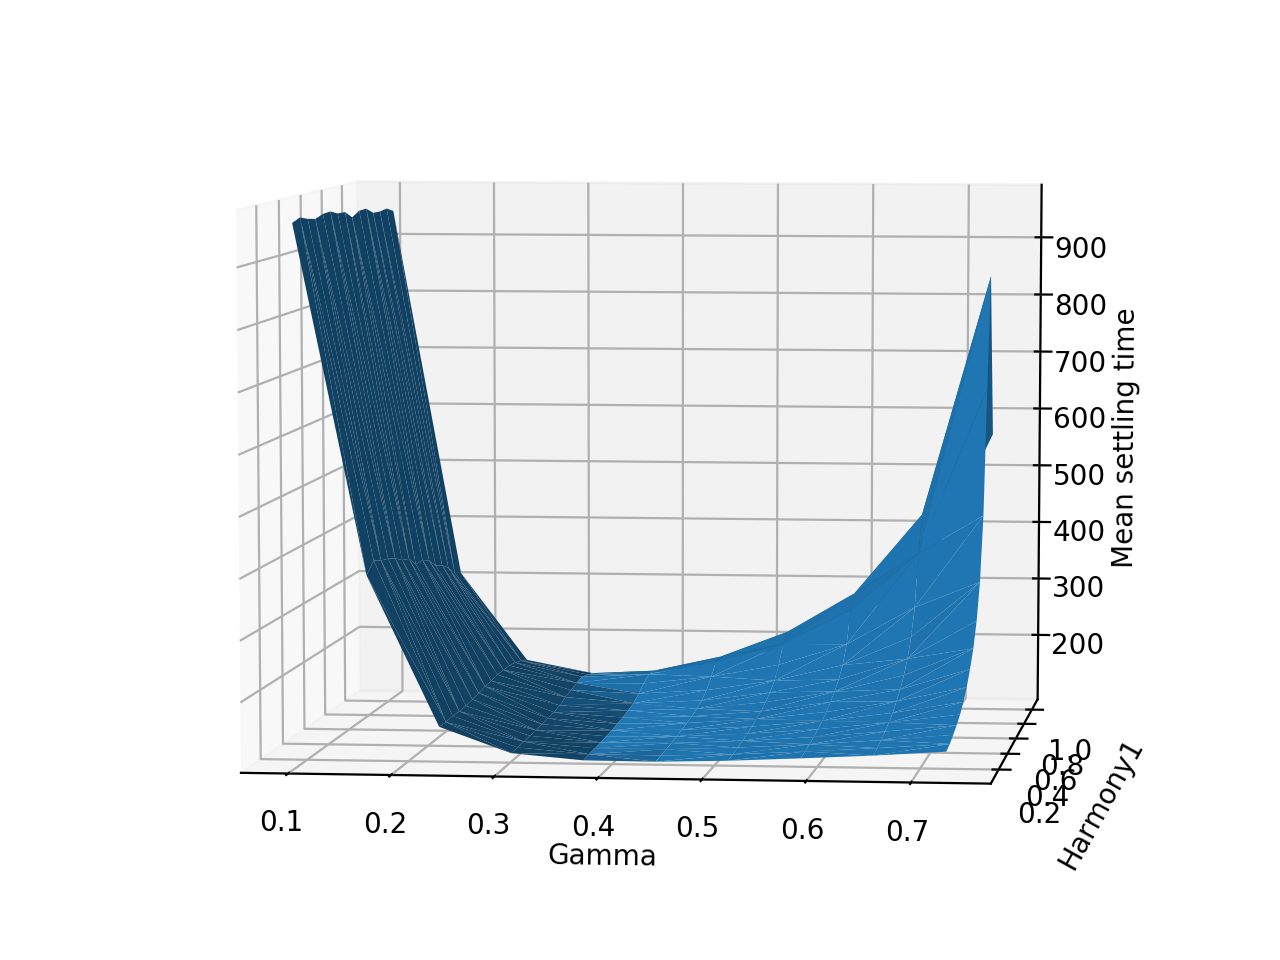

In [20]:
# Plotting the surface
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg2.Gamma, agg2.Harmony1, agg2.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('Gamma')
ax.set_ylabel('Harmony1')
ax.set_zlabel('Mean settling time')
plt.show()

<IPython.core.display.Javascript object>


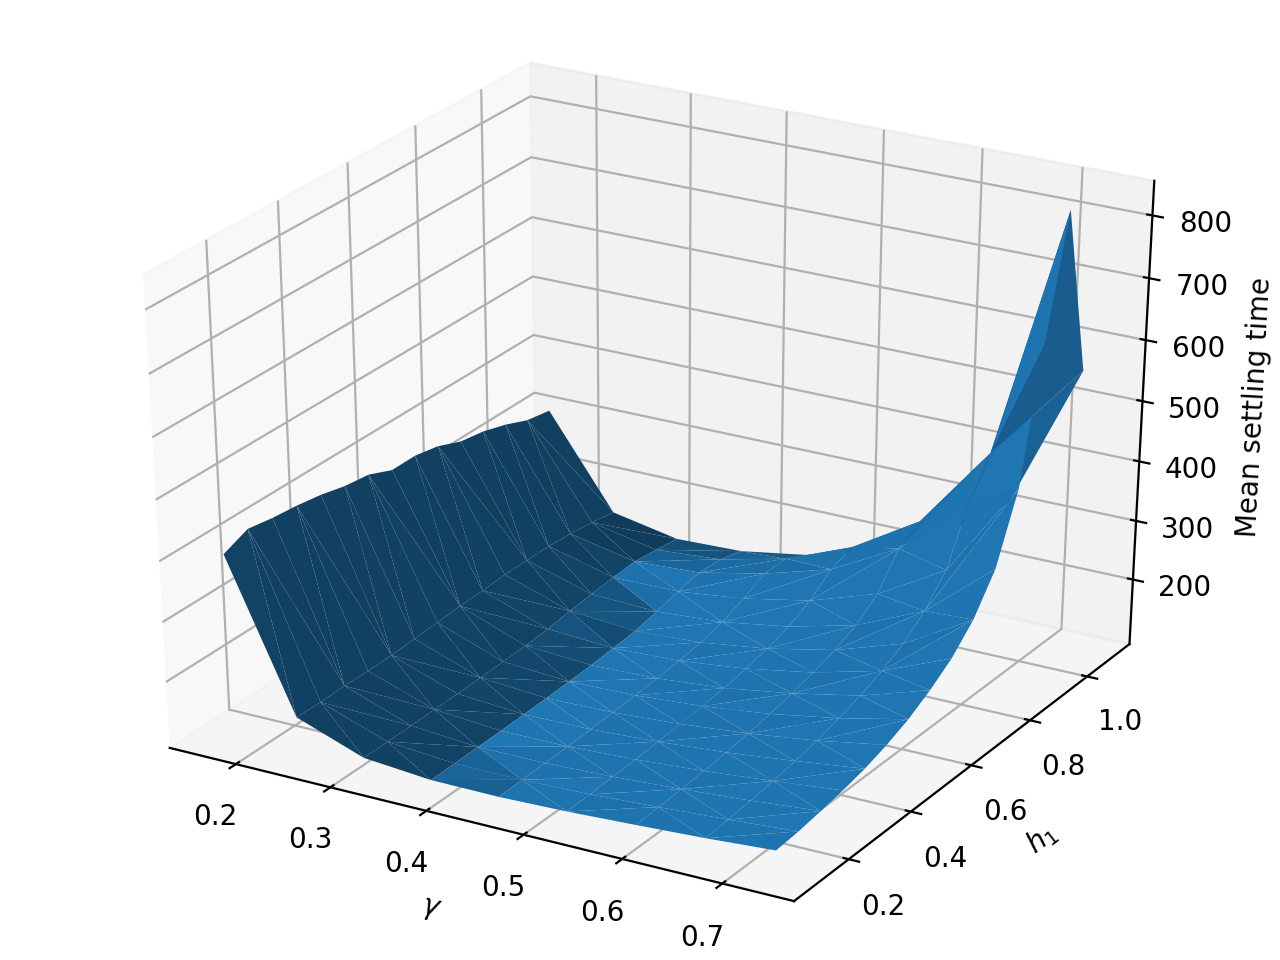

In [32]:
# For gamma < 0.2, it basically never finds an attractor, so let's zoom in, leaving that out
agg_subset = agg2.loc[agg2.Gamma > 0.1,]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg_subset.Gamma, agg_subset.Harmony1, agg_subset.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$h_1$')
ax.set_zlabel('Mean settling time')
plt.show()

**check stopping criterion for this, although, for $\gamma <= 0.7$, there should be separate attractors**

<IPython.core.display.Javascript object>


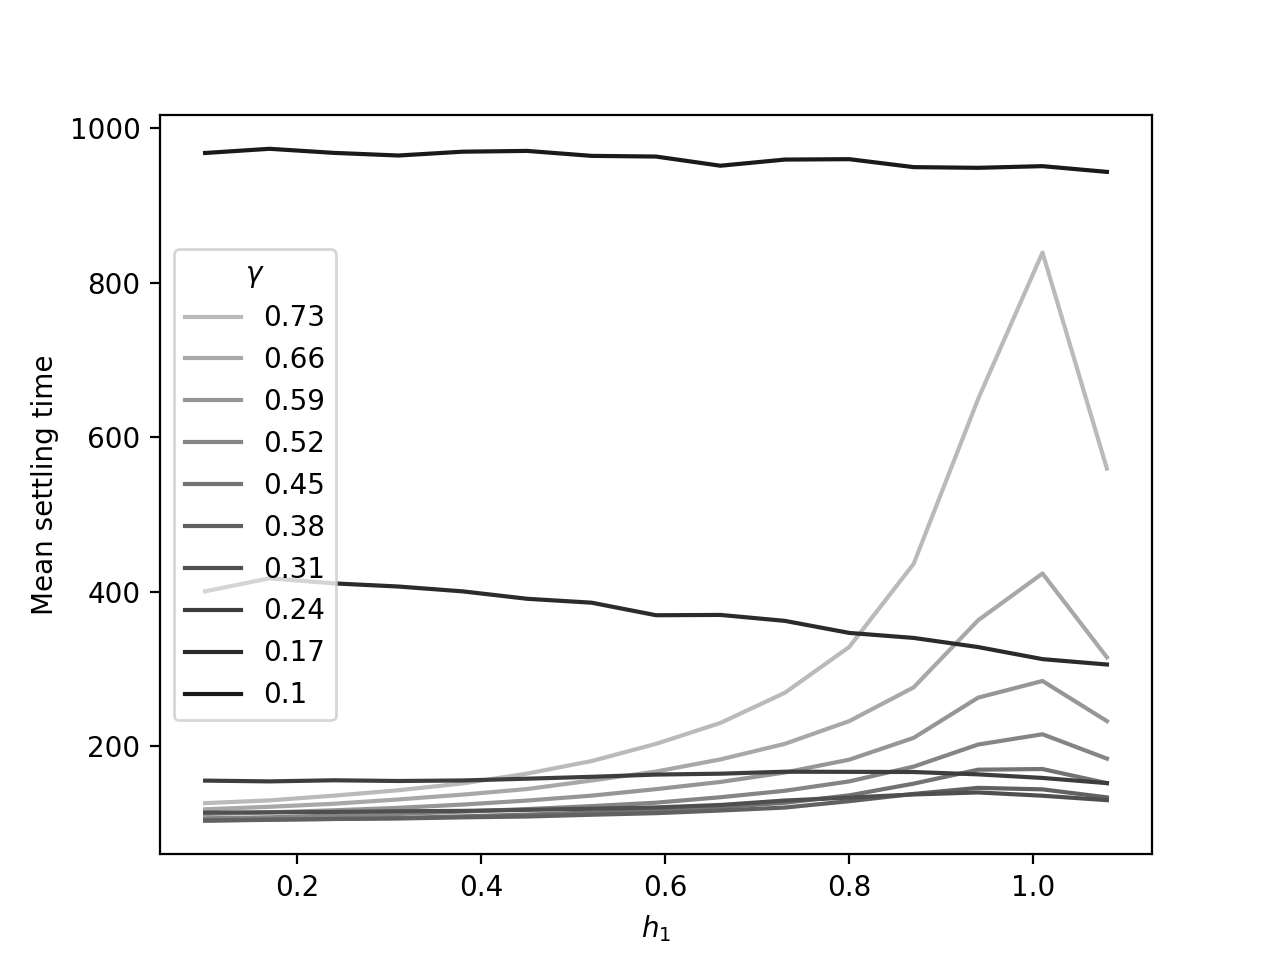

In [42]:
# Plotting mean RTs as a fn. of h1, with a separate curve for each value of gamma
plt.figure()
for g in gvals[::-1]:
    plt.plot(agg2.loc[agg2.Gamma == g].Harmony1, agg2.loc[agg2.Gamma == g].Time, color=str(g), label=g)
plt.legend(title='$\gamma$')
plt.ylabel('Mean settling time')
plt.xlabel('$h_1$')
plt.show()

Maybe consider only using $\gamma$ values that produce at least a 10% increase in reading times as competition increases (max. diff.)